In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy as jsp

from pyscf import gto, scf, ao2mo, cc

from dataclasses import dataclass
from typing import Tuple
import itertools
import importlib

import wavefunctions, hamiltonian, trajectory

/home/amress/miniforge3/envs/nqs/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/amress/miniforge3/envs/nqs/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
@dataclass
class ueg:
    r_s: float
    n_elec: Tuple[int, int]
    dim: int = 3

    box_length: float = 0.0
    rec_lattice: Tuple[float, ...] = ()
    volume: float = 0.0  
    n_particles: int = 0
    density: float = 0.0
    seed: int = 0

    def __post_init__(self):
        assert self.dim in (2, 3), "Only dim=2 or dim=3 are supported."
        assert (
            self.n_elec[0] == self.n_elec[1]
        ), "Only unpolarized systems are supported."

        self.n_particles = int(self.n_elec[0] + self.n_elec[1])

        if self.dim == 3:
            # V = (4π/3) r_s^3 N  =>  L = V^(1/3)
            vol = (4.0 / 3.0) * jnp.pi * (self.r_s**3) * self.n_particles
            self.box_length = vol ** (1.0 / 3.0)
            self.volume = self.box_length**3
        else:
            # A = π r_s^2 N  =>  L = sqrt(A)
            area = jnp.pi * (self.r_s**2) * self.n_particles
            self.box_length = jnp.sqrt(area)
            self.volume = self.box_length**2

        self.rec_lattice = (2.0 * jnp.pi / self.box_length,) * self.dim
        self.density = self.n_particles / self.volume

    def _paired_kpoints_from_nvecs(self, nvecs: np.ndarray) -> jax.Array:
        nvecs = np.asarray(nvecs, dtype=int)
        assert nvecs.ndim == 2 and nvecs.shape[1] == self.dim

        zero = tuple([0] * self.dim)
        n_set = {tuple(v) for v in nvecs.tolist()}
        if zero not in n_set:
            nvecs = np.vstack([np.zeros((1, self.dim), dtype=int), nvecs])
            n_set.add(zero)

        n2 = np.sum(nvecs**2, axis=1)
        order = np.argsort(n2, kind="stable")
        nvecs = nvecs[order]

        result_n: list[tuple[int, ...]] = [zero]
        processed: set[tuple[int, ...]] = {zero}
        canonicals: list[tuple[int, ...]] = []

        for n in nvecs:
            t = tuple(int(x) for x in n.tolist())
            if t in processed or t == zero:
                continue
            neg = tuple(-x for x in t)
            if neg not in n_set:
                processed.add(t)
                continue

            c = None
            for x in t:
                if x != 0:
                    c = t if x > 0 else neg
                    break
            if c is None:
                continue

            processed.add(c)
            processed.add(tuple(-x for x in c))
            canonicals.append(c)

        canonicals.sort(key=lambda v: sum(x * x for x in v))
        for c in canonicals:
            result_n.append(c)
            result_n.append(tuple(-x for x in c))

        B = np.diag(np.array(self.rec_lattice, dtype=float))
        kpts = np.array(result_n, dtype=float) @ B.T
        return jnp.asarray(kpts)

    def get_occ_k_points(self) -> jax.Array:
        dk = 1.0 + 1e-5
        n_up = int(self.n_elec[0])

        max_n = int(np.ceil((n_up * dk) ** (1.0 / self.dim))) + 2
        ordinals = sorted(range(-max_n, max_n + 1), key=abs)
        nvecs = np.array(list(itertools.product(ordinals, repeat=self.dim)), dtype=int)

        n2 = np.sum(nvecs**2, axis=1)
        order = np.argsort(n2, kind="stable")
        nvecs = nvecs[order]
        n2 = n2[order]

        n2F = n2[n_up - 1]
        keep = n2 <= (n2F * dk * dk + 1e-12)
        return self._paired_kpoints_from_nvecs(nvecs[keep])

    def _calc_dis(self, pos: jax.Array):
        box = jnp.full((self.dim,), self.box_length)

        pos_up = pos[0]
        pos_dn = pos[1]
        pos_flat = jnp.concatenate([pos_up, pos_dn], axis=0)
        n_particles = pos_flat.shape[0]

        def get_disp(i, j):
            dr = pos_flat[i] - pos_flat[j]
            dr = dr - box * jnp.round(dr / box)
            return dr

        disp = vmap(
            lambda i: vmap(get_disp, in_axes=(None, 0))(i, jnp.arange(n_particles))
        )(jnp.arange(n_particles))
        dist = jnp.sqrt(jnp.sum(disp**2, axis=-1) + 1e-10)
        mask = ~jnp.eye(n_particles, dtype=bool)
        dist = jnp.where(mask, dist, 0.0)
        return dist, disp

    def init_walker_data(self, n_walkers: int) -> dict:
        def walker_init(subkey):
            subkey, subkey_up = random.split(subkey)
            pos_up = (
                random.uniform(subkey_up, (self.n_elec[0], self.dim)) * self.box_length
            )
            subkey, subkey_dn = random.split(subkey)
            pos_dn = (
                random.uniform(subkey_dn, (self.n_elec[1], self.dim)) * self.box_length
            )
            pos = jnp.array([pos_up, pos_dn])
            dist, disp = self._calc_dis(pos)
            return pos, dist, disp

        random_key = random.PRNGKey(self.seed)
        random_key, *subkeys = random.split(random_key, n_walkers + 1)
        pos, dist, disp = vmap(walker_init)(jnp.array(subkeys))
        return {"pos": pos, "dist": dist, "disp": disp, "random_key": random_key}

    def update_walker_data(self, new_pos_batch: jax.Array, walker_data: dict) -> dict:
        assert new_pos_batch.shape == walker_data["pos"].shape

        def update_single_walker(carry, new_pos_i):
            dist, disp = self._calc_dis(new_pos_i)
            return carry, (dist, disp)

        _, (dist, disp) = lax.scan(update_single_walker, None, new_pos_batch)
        walker_data["dist"] = dist
        walker_data["disp"] = disp
        walker_data["pos"] = new_pos_batch
        return walker_data

    def __hash__(self) -> int:
        return hash(tuple(self.__dict__.values()))


@dataclass
class ueg_qc(ueg):
    """Plane-wave QC Hamiltonian for 2D/3D UEG (square/cubic cell)."""

    e_cut_red: float = 1.0

    madelung_alpha_3d: float = 2.837297479
    madelung_alpha_2d: float = 3.90026492000195

    def get_k_points(self) -> jax.Array:
        max_n = int(np.ceil(np.sqrt(2.0 * float(self.e_cut_red)))) + 1
        ns = np.arange(-max_n, max_n + 1, dtype=int)
        nvecs = np.array(list(itertools.product(ns, repeat=self.dim)), dtype=int)

        eps_red = 0.5 * np.sum(nvecs**2, axis=1)
        keep = eps_red <= (float(self.e_cut_red) + 1e-12)
        return self._paired_kpoints_from_nvecs(nvecs[keep])

    def madelung(self) -> jax.Array:
        alpha = self.madelung_alpha_3d if self.dim == 3 else self.madelung_alpha_2d
        return -alpha * self.n_particles / self.box_length

    def get_h1(self, k_points: jax.Array) -> jax.Array:
        h1 = jnp.diag(jnp.sum(k_points**2, axis=-1) / 2)
        mad = 0.5 * self.madelung() / self.n_particles
        return h1 + mad * jnp.eye(k_points.shape[0])

    def get_h1_real(self, k_points: jax.Array) -> jax.Array:
        h1_pw = self.get_h1(k_points)
        U = self.unitary_pw_to_real(k_points)
        return (U.conj() @ h1_pw @ U.T).real

    def eri_element(self, k_points: jax.Array, p, q, r, s) -> jax.Array:
        g1 = k_points[q] - k_points[p]
        g2 = k_points[r] - k_points[s]
        mom_ok = jnp.all(jnp.isclose(g1, g2), axis=-1)

        if self.dim == 3:
            g2norm = jnp.sum(g1 * g1, axis=-1)
            non_zero = g2norm > 1e-10
            # ~ 4π/(V |g|^2) for g!=0
            element = 4.0 * jnp.pi / (self.volume * g2norm)
        else:
            gnorm = jnp.linalg.norm(g1, axis=-1)
            non_zero = gnorm > 1e-10
            # ~ (2π q)/(A |g|) for g!=0 (q=1), k=0 term set to 0
            element = 2.0 * jnp.pi / (self.volume * gnorm)

        element = jnp.where(jnp.isinf(element) | jnp.isnan(element), 0.0, element)
        return mom_ok * non_zero * element

    def get_eri_tensor(self, k_points: jax.Array) -> jax.Array:
        n = k_points.shape[0]
        idx = jnp.arange(n)
        p, q, r, s = jnp.meshgrid(idx, idx, idx, idx, indexing="ij")
        eri_flat = self.eri_element(
            k_points, p.ravel(), q.ravel(), r.ravel(), s.ravel()
        )
        return eri_flat.reshape(n, n, n, n)

    def unitary_pw_to_real(self, k_points: jax.Array) -> jax.Array:
        n_kpts = k_points.shape[0]
        assert (n_kpts - 1) % 2 == 0, "k_points must be Gamma + pairs."
        U = jnp.zeros((n_kpts, n_kpts), dtype=jnp.complex128)

        block = jnp.array([[1.0, 1.0], [-1.0j, 1.0j]]) / jnp.sqrt(2.0)
        n_blocks = (n_kpts - 1) // 2

        U = U.at[0, 0].set(1.0)
        U = U.at[1:, 1:].set(jsp.linalg.block_diag(*([block] * n_blocks)))
        return U

    def get_eri_tensor_real(self, k_points: jax.Array) -> jax.Array:
        eri = self.get_eri_tensor(k_points)
        U = self.unitary_pw_to_real(k_points)
        eri = jnp.einsum("ip,pqrs->iqrs", U.conj(), eri, optimize=True)
        eri = jnp.einsum("jq,iqrs->ijrs", U, eri, optimize=True)
        eri = jnp.einsum("kr,ijrs->ijks", U.conj(), eri, optimize=True)
        eri = jnp.einsum("ls,ijks->ijkl", U, eri, optimize=True).real
        return eri

    def __hash__(self):
        return hash(tuple(self.__dict__.values()))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(256, 2, 2)


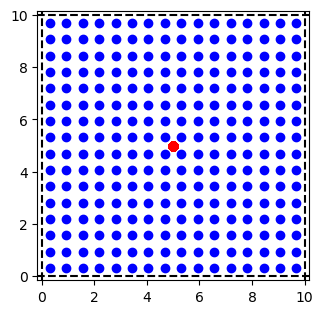

In [3]:
def makeTwoElectronGrid(gridPoints, dim, L):
    """
    Creates configurations for 2 electrons:
      - Electron 0: Fixed at center (L/2, ...)
      - Electron 1: Scans grid midpoints
    Returns: rs with shape (gridPoints^dim, 2, dim)
    """
    # Generate 1D coordinates (midpoints of grid cells)
    coords = jnp.linspace(0, L, gridPoints, endpoint=False) + (L / gridPoints / 2)
    
    # Create meshgrid for 'dim' dimensions
    grids = jnp.meshgrid(*([coords] * dim), indexing='ij')
    
    # Flatten to get scanning positions: (TotalPoints, dim)
    scan_pos = jnp.stack(grids, axis=-1).reshape(-1, dim)
    
    # Create fixed positions: (TotalPoints, dim)
    fixed_pos = jnp.full_like(scan_pos, L / 2)
    
    # Stack electron 0 (fixed) and electron 1 (scanning): (TotalPoints, 2, dim)
    rs = jnp.stack([fixed_pos, scan_pos], axis=1)
    
    return rs

gridPoints = 16
dim = 2
L = 10

rs = makeTwoElectronGrid(gridPoints, dim, L)
print(rs.shape)

plt.figure(figsize=(3.5,3.5))
plt.scatter(rs[:,0,0], rs[:,0,1], color='red')
plt.scatter(rs[:,1,0], rs[:,1,1], color='blue')
plt.axvline(x=0, color='black', linestyle='--')
plt.axvline(x=L, color='black', linestyle='--')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=L, color='black', linestyle='--')
plt.show()

In [9]:
importlib.reload(wavefunctions)
importlib.reload(hamiltonian)

spins = (1,1)
dim = 3

gridPoints = 96
N = spins[0] + spins[1]

for r_ws in [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]:

    L = wavefunctions.computeL(N, r_ws, dim)

    system = ueg_qc(r_ws, spins, dim=dim, e_cut_red=0.0)
    #system = ueg_qc(r_ws, spins, dim=dim, e_cut_red=5.0)
    k_points = system.get_k_points()
    n_kpts = k_points.shape[0]
    if n_kpts != 1:
        raise Exception("Too many k-points for some reason!")
    h1 = system.get_h1_real(k_points)
    eri_jax = system.get_eri_tensor_real(k_points)
    eri = np.asarray(eri_jax, dtype=np.double)
    
    mol = gto.M(verbose=0)
    mol.nelectron = system.n_particles
    mol.incore_anyway = True
    mol.energy_nuc = lambda *args: 0.0
    mol.verbose = 0
    
    mf = scf.RHF(mol)
    mf.get_hcore = lambda *args: h1
    mf.get_ovlp = lambda *args: np.eye(n_kpts)
    mf._eri = ao2mo.restore(8, eri, n_kpts)
    mf.init_guess = "1e"
    escf = mf.kernel()

    wavefunction = wavefunctions.LogSimpleSlaters(spins, L, dim=3)
    localEnergy = hamiltonian.LocalEnergyUEG(wavefunction, L)

    rng = jax.random.PRNGKey(558)

    rng, rs_rng, init_rng = jax.random.split(rng, 3)
    rs = trajectory.wignerCrystal(spins, r_ws, L, 8, rs_rng, dim=3)
    parameters = wavefunction.initBatch(init_rng, rs)
    rs = makeTwoElectronGrid(gridPoints, dim, L)

    wfVals = wavefunction.applyBatch(parameters, rs)
    energies = localEnergy.batch(parameters, rs)
    weights = jnp.exp(2.0 * wfVals)
    vmc_energy = jnp.average(energies, weights=weights)
    
    print(f"r_s: {r_ws}\tSCF: {escf}\tVMC: {vmc_energy}")

/tmp/ipykernel_7114/4217349719.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  U = jnp.zeros((n_kpts, n_kpts), dtype=jnp.complex128)


r_s: 1.0	SCF: -1.3970072269439697	VMC: -1.3970528841018677
r_s: 2.0	SCF: -0.6985036134719849	VMC: -0.6985264420509338
r_s: 5.0	SCF: -0.2794014513492584	VMC: -0.27941060066223145
r_s: 10.0	SCF: -0.1397007256746292	VMC: -0.13970530033111572
r_s: 20.0	SCF: -0.0698503628373146	VMC: -0.06985265016555786
r_s: 50.0	SCF: -0.027940144762396812	VMC: -0.027941059321165085
r_s: 100.0	SCF: -0.013970072381198406	VMC: -0.013970529660582542


In [7]:
importlib.reload(wavefunctions)
importlib.reload(hamiltonian)

spins = (1,1)
dim = 2

gridPoints = 1024
N = spins[0] + spins[1]

for r_ws in [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]:

    L = wavefunctions.computeL(N, r_ws, dim)

    system = ueg_qc(r_ws, spins, dim=dim, e_cut_red=0.0)
    #system = ueg_qc(r_ws, spins, dim=dim, e_cut_red=5.0)
    k_points = system.get_k_points()
    n_kpts = k_points.shape[0]
    if n_kpts != 1:
        raise Exception("Too many k-points for some reason!")
    h1 = system.get_h1_real(k_points)
    eri_jax = system.get_eri_tensor_real(k_points)
    eri = np.asarray(eri_jax, dtype=np.double)
    
    mol = gto.M(verbose=0)
    mol.nelectron = system.n_particles
    mol.incore_anyway = True
    mol.energy_nuc = lambda *args: 0.0
    mol.verbose = 0
    
    mf = scf.RHF(mol)
    mf.get_hcore = lambda *args: h1
    mf.get_ovlp = lambda *args: np.eye(n_kpts)
    mf._eri = ao2mo.restore(8, eri, n_kpts)
    mf.init_guess = "1e"
    escf = mf.kernel()

    wavefunction = wavefunctions.LogSimpleSlaters(spins, L, dim=dim)
    localEnergy = hamiltonian.LocalEnergyUEG2D(wavefunction, L)

    rng = jax.random.PRNGKey(558)

    rng, rs_rng, init_rng = jax.random.split(rng, 3)
    rs = trajectory.wignerCrystal(spins, r_ws, L, 8, rs_rng, dim=dim)
    parameters = wavefunction.initBatch(init_rng, rs)
    rs = makeTwoElectronGrid(gridPoints, dim, L)

    wfVals = wavefunction.applyBatch(parameters, rs)
    energies = localEnergy.batch(parameters, rs)
    weights = jnp.exp(2.0 * wfVals)
    vmc_energy = jnp.average(energies, weights=weights)
    
    print(f"r_s: {r_ws}\tSCF: {escf}\tVMC: {vmc_energy}")

/tmp/ipykernel_7114/4217349719.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  U = jnp.zeros((n_kpts, n_kpts), dtype=jnp.complex128)


r_s: 1.0	SCF: -1.5559805631637573	VMC: -1.5566115379333496
r_s: 2.0	SCF: -0.7779902815818787	VMC: -0.7783057689666748
r_s: 5.0	SCF: -0.31119611859321594	VMC: -0.31132233142852783
r_s: 10.0	SCF: -0.15559805929660797	VMC: -0.15566116571426392
r_s: 20.0	SCF: -0.07779902964830399	VMC: -0.07783058285713196
r_s: 50.0	SCF: -0.031119612976908684	VMC: -0.031132230535149574
r_s: 100.0	SCF: -0.015559806488454342	VMC: -0.015566115267574787
